# Changes:
1. Based on V37
2. Refactored data augmentor. Re-implement the rotate function to preserve positive mask area.
3. Changed optimizer to adam

## Install required packages if running on google colab

In [0]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [3]:
cd salt_oil

/content/salt_oil


In [0]:
!git checkout 7b7f45978f493ae15f06202eb17c220c2c6d850d .

## Import required libs

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [8]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.cuda.FloatTensor'>


In [0]:
def setup_train(config_list):
    for conf in config_list:
        log.info(conf)
    for conf in config_list:
        exec(conf)

## Create Logger

In [0]:
run_name = 'salt_model_v37.42_high_lovasz_loss_cv0'
model_file_suffix = f'../salt_net/{run_name}_{get_current_time_as_fname()}.ckp'
fold = 0

In [0]:
global log
log = get_logger(run_name)

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [12]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Train Val data split

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])
df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)
nfolds = list(skf.split(df_train_mask.index.tolist(), df_train_mask.mask_pix))

In [0]:
X_train_ids = np.r_[nfolds[fold]][:3200]
X_val_ids = np.r_[nfolds[fold]][3200:]

In [0]:
#df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])
#df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

#X_train_ids, X_val_ids = (
#    train_test_split(df_train_mask.index.tolist(), 
#                     test_size=0.20,
#                     stratify = df_train_mask.mask_pix,
#                     random_state=0)
#)

X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)
#set mean image to 0 as mean is now being handled within the model.
X_train_mean_img = np.zeros_like(X_train_mean_img)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

assert X_train_mean_img == np.array([0.])
assert X_train.shape == (3200, 101, 101, 1)
assert y_train.shape == (3200, 101, 101, 1)
assert depth_train.shape == (3200, 1)

## Train the full with full dataset

In [17]:
log.info(f'{run_name}, based on salt_model_v37.4_high_lovasz_loss. 5 folds CV.')

09/10/2018 10:42:28 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - salt_model_v37.42_high_lovasz_loss_cv0, based on salt_model_v37.4_high_lovasz_loss. 5 folds CV.


In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.rotate90(0.25)
p.rotate270(0.25)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}
'''

In [0]:
model_config = '''
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)
optimizer = optim.Adam([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
], weight_decay=0.0001)


scheduler = PolyLR(optimizer, [1e-4, 1e-3], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = model_file_suffix
log.info(model_save_name)
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 150,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.81
    }
'''

In [0]:
model_run_config = '''
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.3), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

09/10/2018 10:42:58 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - 
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.rotate90(0.25)
p.rotate270(0.25)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)

09/10/2018 10:42:58 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - 
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform())

ResNet using pretrained weights.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 15961975.33it/s]
09/10/2018 10:43:08 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - ../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp
09/10/2018 10:43:08 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - Start Training...
09/10/2018 10:43:08 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - ({'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc55fad8828>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc592c94908>}, (BCEWithLogitsLoss(), LovaszHingeLoss()), (1, 0.3), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0001
), <salt_func_lib.PolyLR object at 0x7fc5155ac7b8>, {'model_save_name

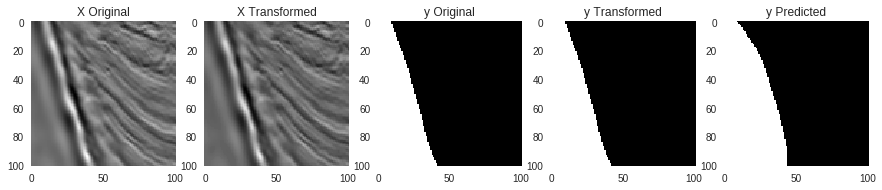

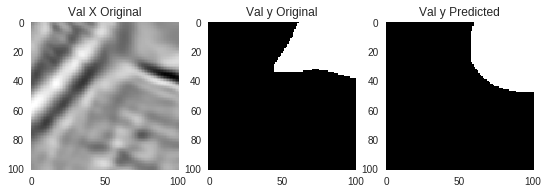

09/10/2018 10:46:42 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - ['../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-1-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-2-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-3-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-4-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-5-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-6-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-7-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-8-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-9-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-10-Of-10']
09/10/20

/content/salt_net
From https://github.com/allen-q/salt_net
 * [new branch]      master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master cd8c25e] Pushing logs to git
 3 files changed, 108 insertions(+)
 create mode 100644 logs/SaltNet_2018_10_09_21h.log
 create mode 100644 logs/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21h.log
 create mode 100644 logs/salt_model_v37.42_high_lovasz_loss_cv_2018_10_09_20h.log
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 1.77 KiB | 1.77 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/all

09/10/2018 10:50:12 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - Train IOU: 0.6085, Acc: 0.8859, Loss: [0.4328, 0.2366, 0.6694] at epoch 2


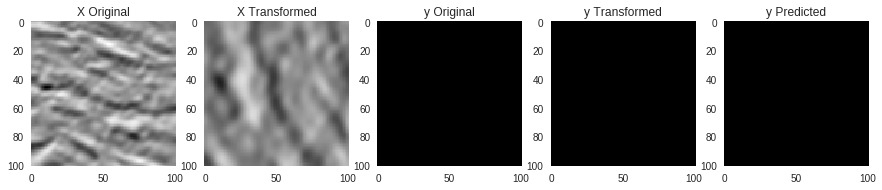

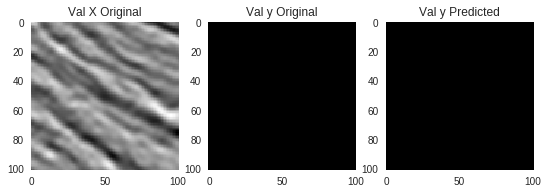

09/10/2018 10:50:29 - salt_model_v37.42_high_lovasz_loss_cv0 - INFO - ['../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-1-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-2-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-3-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-4-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-5-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-6-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-7-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-8-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-9-Of-10', '../salt_net/salt_model_v37.42_high_lovasz_loss_cv0_2018_10_09_21_41_43.ckp-chunk-10-Of-10']
09/10/20

In [0]:
setup_train(config_list)

## Load Trained Model

In [0]:
cd ../salt_net

In [0]:
loaded_model = UResNet(pretrained=False)

#model_file_suffix = "Unet_res34_bce_lovasz_loss_se_new_aug_finetuen1_2018_09_21_09_41_48.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [0]:
loaded_model.eval()
assert loaded_model.training == False

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
if torch.cuda.is_available():
    loaded_model.cuda()

### Eval model on Val data set

In [0]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=16)
y_val_pred_flip = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred_flip.append(loaded_model(X_val_batch))
y_val_pred_flip = torch.cat(y_val_pred_flip)
y_val_pred_flip = torch.flip(y_val_pred_flip,[2])

#### merge normal pred and hflip pred

In [0]:
y_val_pred_ens = torch.where(y_val_pred.abs() > y_val_pred_flip.abs(), y_val_pred, y_val_pred_flip)

#### Check normal pred IOU

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(0), y_val.squeeze())

#### Check TTA pred IOU

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(0), y_val.squeeze())

### Find best mask cutoff

In [0]:
results=[]
for cut_off in np.r_[-0.1:0.1:50j]:
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(0, X_val, y_val_pred_ens.gt(cut_off), y_val.squeeze()), y_val.squeeze()))

In [0]:
MASK_CUTOFF = np.r_[-0.1:0.1:50j][np.argmax(results)]
ZERO_MASK_CUTOFF = 0

In [0]:
log.info(f'MASK_CUTOFF: {MASK_CUTOFF}')
log.info(f'ZERO_MASK_CUTOFF: {ZERO_MASK_CUTOFF}')

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze())

## Make predictions on test set using TTA

In [0]:
import numpy as np

### Predict using original image

In [0]:
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=32)

In [0]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Predict using flipped images

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=32)
y_test_pred_flip = []

with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_flip.append(loaded_model(X_test_batch))
y_test_pred_flip = torch.cat(y_test_pred_flip)
y_test_pred_flip = torch.flip(y_test_pred_flip,[2])

### Combine non-flip and flip predictions

In [0]:
y_test_pred_ens = torch.where(y_test_pred.abs() > y_test_pred_flip.abs(), y_test_pred, y_test_pred_flip)

### Adjust predictions

In [0]:
#MASK_CUTOFF = 0
#ZERO_MASK_CUTOFF = 0

In [0]:
log.info(f'MASK_CUTOFF:{MASK_CUTOFF}, ZERO_MASK_CUTOFF:{ZERO_MASK_CUTOFF}')

In [0]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred_ens.gt(MASK_CUTOFF))


### Prepare for submission

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [0]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
sub_fname = f'submission_{get_current_time_as_fname()}.csv'

In [0]:
df_test_rle.to_csv(sub_fname, index=False)

In [0]:
log.info(f'submission file {sub_fname} generated.')

In [0]:
from google.colab import files

In [0]:
files.download(sub_fname) 

In [0]:
log.info(f'submission file {sub_fname} downloaded.')

In [0]:
data_dict = {'run_name': run_name,
             'y_val_pred': y_val_pred,
             'y_val_pred_flip': y_val_pred_flip,
             'y_val_pred_ens': y_val_pred_ens,
             'y_test_pred':, y_test_pred,
             'y_test_pred_flip':, y_test_pred_flip,
             'y_test_pred_adj':, y_test_pred_adj,
             'df_test_rle': df_test_rle}

In [0]:
import pickle

with open(f'{run_name}_{get_current_time_as_fname()}.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [0]:
push_model_to_git()